In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.naive import NaiveForecaster
from sktime.split import SlidingWindowSplitter

METHOD 1: Single Serie with SlidingWindowSplitter and Forecasting

Mean Forecast - MAPE (Last 10 Observations): 10.78%
Last Forecast - MAPE (Last 10 Observations): 9.22%


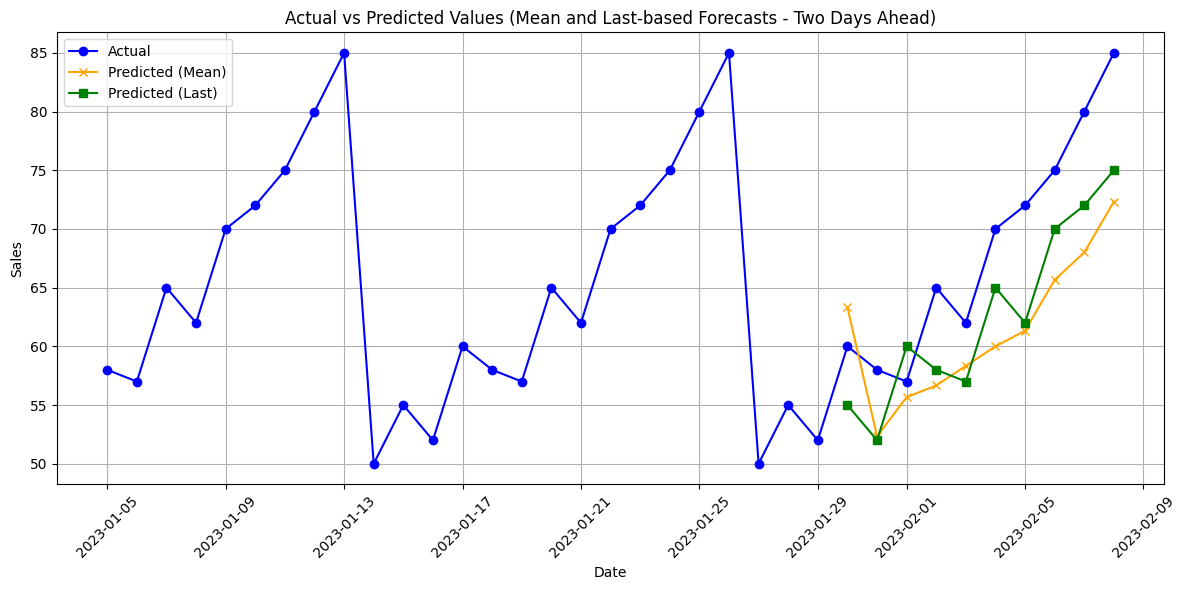

            Actual  Predicted Mean  Predicted Last
2023-01-05      58             NaN             NaN
2023-01-06      57             NaN             NaN
2023-01-07      65             NaN             NaN
2023-01-08      62             NaN             NaN
2023-01-09      70             NaN             NaN
2023-01-10      72             NaN             NaN
2023-01-11      75             NaN             NaN
2023-01-12      80             NaN             NaN
2023-01-13      85             NaN             NaN
2023-01-14      50             NaN             NaN
2023-01-15      55             NaN             NaN
2023-01-16      52             NaN             NaN
2023-01-17      60             NaN             NaN
2023-01-18      58             NaN             NaN
2023-01-19      57             NaN             NaN
2023-01-20      65             NaN             NaN
2023-01-21      62             NaN             NaN
2023-01-22      70             NaN             NaN
2023-01-23      72             

In [31]:
# Example time series data (daily sales data with dates)
date_rng = pd.date_range(start='2023-01-01', end='2023-02-08', freq='D')  # Corrected end date
sales_data = [50, 55, 52, 60, 58, 57, 65, 62, 70, 72, 75, 80, 85] * 3
y = pd.Series(sales_data, index=date_rng, name="sales")

# Set splitter parameters
window_length = 3  # Training window length
fh = [2]  # Forecast two days ahead (day after tomorrow)
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)

# Get the number of splits and generate training/test windows
def get_windows(y, cv):
    train_windows = []  
    test_windows = []   
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)  
        test_windows.append(test)     
    return train_windows, test_windows  

train_windows, test_windows = get_windows(y, cv)

# Initialize lists to store predictions
predictions_mean = []
predictions_last = []

# Iterate over each split (window)
for i in range(len(train_windows)):
    train_idx = train_windows[i]
    test_idx = test_windows[i]
    
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # Forecasting with "mean" strategy
    forecaster_mean = NaiveForecaster(strategy="mean")
    forecaster_mean.fit(y_train)
    y_pred_mean = forecaster_mean.predict(fh=fh)
    predictions_mean.append(y_pred_mean)

    # Forecasting with "last" strategy
    forecaster_last = NaiveForecaster(strategy="last")
    forecaster_last.fit(y_train)
    y_pred_last = forecaster_last.predict(fh=fh)
    predictions_last.append(y_pred_last)

# Combine predictions into series
predictions_mean_series = pd.Series(np.concatenate(predictions_mean), index=y.index[window_length + 1:])
predictions_last_series = pd.Series(np.concatenate(predictions_last), index=y.index[window_length + 1:])

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Actual': y.iloc[window_length + 1:],  
    'Predicted Mean': predictions_mean_series,
    'Predicted Last': predictions_last_series
})

# Keep all actual observations and only the last 10 for predictions
results_df['Predicted Mean'] = results_df['Predicted Mean'].where(results_df.index.isin(results_df.index[-10:]), np.nan)
results_df['Predicted Last'] = results_df['Predicted Last'].where(results_df.index.isin(results_df.index[-10:]), np.nan)

# Calculate MAPE for the last 10 observations
last_10_results_df = results_df.tail(10)

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

# Calculate MAPE for both prediction strategies based on the last 10 observations/This is sort of a test/split. 

mape_mean_last_10 = mean_absolute_percentage_error(last_10_results_df['Actual'], last_10_results_df['Predicted Mean'])
mape_last_last_10 = mean_absolute_percentage_error(last_10_results_df['Actual'], last_10_results_df['Predicted Last'])

print(f"Mean Forecast - MAPE (Last 10 Observations): {mape_mean_last_10:.2f}%")
print(f"Last Forecast - MAPE (Last 10 Observations): {mape_last_last_10:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual', marker='o', color='blue')
plt.plot(results_df.index, results_df['Predicted Mean'], label='Predicted (Mean)', marker='x', color='orange')
plt.plot(results_df.index, results_df['Predicted Last'], label='Predicted (Last)', marker='s', color='green')

plt.title('Actual vs Predicted Values (Mean and Last-based Forecasts - Two Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show the results (first 20 days for preview)
print(results_df.head(20))


METHOD 2: Single Serie with lagged features

            Actual  Predicted Last  Predicted Mean
2023-01-01      50             NaN             NaN
2023-01-02      55             NaN             NaN
2023-01-03      52            50.0             NaN
2023-01-04      60            55.0             NaN
2023-01-05      58            52.0       52.333333
2023-01-06      57            60.0       55.666667
2023-01-07      65            58.0       56.666667
2023-01-08      62            57.0       58.333333
2023-01-09      70            65.0       60.000000
2023-01-10      72            62.0       61.333333
2023-01-11      75            70.0       65.666667
2023-01-12      80            72.0       68.000000
2023-01-13      85            75.0       72.333333
2023-01-14      50            80.0       75.666667
2023-01-15      55            85.0       80.000000
2023-01-16      52            50.0       71.666667
2023-01-17      60            55.0       63.333333
2023-01-18      58            52.0       52.333333
2023-01-19      57            6

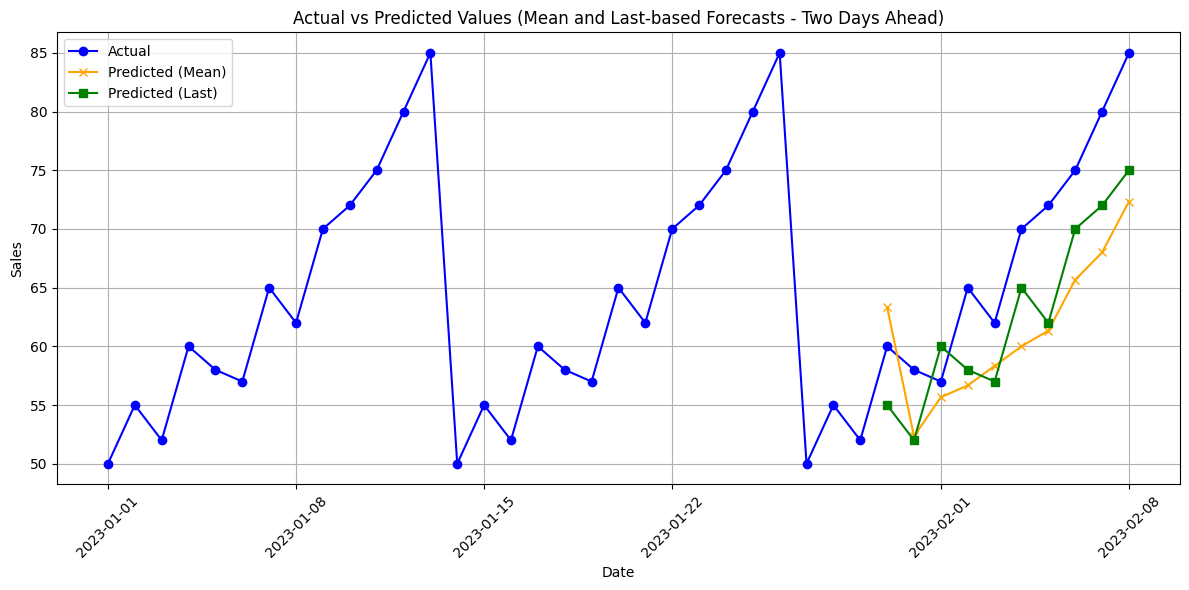

            Actual  Predicted Last  Predicted Mean
2023-01-01      50             NaN             NaN
2023-01-02      55             NaN             NaN
2023-01-03      52             NaN             NaN
2023-01-04      60             NaN             NaN
2023-01-05      58             NaN             NaN
2023-01-06      57             NaN             NaN
2023-01-07      65             NaN             NaN
2023-01-08      62             NaN             NaN
2023-01-09      70             NaN             NaN
2023-01-10      72             NaN             NaN
2023-01-11      75             NaN             NaN
2023-01-12      80             NaN             NaN
2023-01-13      85             NaN             NaN
2023-01-14      50             NaN             NaN
2023-01-15      55             NaN             NaN
2023-01-16      52             NaN             NaN
2023-01-17      60             NaN             NaN
2023-01-18      58             NaN             NaN
2023-01-19      57             

In [32]:

# Example time series data (daily sales data with dates)
date_rng = pd.date_range(start='2023-01-01', end='2023-02-08', freq='D')  # Corrected end date
sales_data = [50, 55, 52, 60, 58, 57, 65, 62, 70, 72, 75, 80, 85] * 3
y = pd.Series(sales_data, index=date_rng, name="sales")

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

# Creating the lagged feature (lag of 1 day)
y_lagged = y.shift(2)  # Shift by 1 for a 1-day lag

# Creating the feature where t equals the mean of (t-2, t-3, t-4)
y_rolling_mean = y.shift(2).rolling(window=3).mean()

# Combine these features with the original series in a new DataFrame
Lagging_df = pd.DataFrame({
    'Actual': y,
    'Predicted Last': y_lagged,
    'Predicted Mean': y_rolling_mean
})
print(Lagging_df.head(20))
# Keep all actual observations and only the last 10 for predictions - This servies as Train/Test split 
Lagging_df['Predicted Mean'] = Lagging_df['Predicted Mean'].where(Lagging_df.index.isin(Lagging_df.index[-10:]), np.nan)
Lagging_df['Predicted Last'] = Lagging_df['Predicted Last'].where(Lagging_df.index.isin(Lagging_df.index[-10:]), np.nan)

# Calculate MAPE for the last 10 observations
last_10_results_df = Lagging_df.tail(10)

# Calculate MAPE for both prediction strategies based on the last 10 observations
mape_mean_last_10 = mean_absolute_percentage_error(last_10_results_df['Actual'], last_10_results_df['Predicted Mean'])
mape_last_last_10 = mean_absolute_percentage_error(last_10_results_df['Actual'], last_10_results_df['Predicted Last'])

print(f"Mean Forecast - MAPE (Last 10 Observations): {mape_mean_last_10:.2f}%")
print(f"Last Forecast - MAPE (Last 10 Observations): {mape_last_last_10:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(Lagging_df.index, Lagging_df['Actual'], label='Actual', marker='o', color='blue')
plt.plot(Lagging_df.index, Lagging_df['Predicted Mean'], label='Predicted (Mean)', marker='x', color='orange')
plt.plot(Lagging_df.index, Lagging_df['Predicted Last'], label='Predicted (Last)', marker='s', color='green')

plt.title('Actual vs Predicted Values (Mean and Last-based Forecasts - Two Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show the results (first 20 days for preview)
print(Lagging_df.head(20))



METHOD 3: Multiple Store Serie with Lagged Variables and Overall MAPE 

Final Average MAPE (Mean Forecast): 11.72%
Final Average MAPE (Last Forecast): 9.91%


/var/folders/4z/hxnkb6_x7jn5rtztbhslhxdm0000gn/T/ipykernel_1860/491845832.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['item', 'store'], group_keys=False).apply(add_lagged_features).reset_index(drop=True)
/var/folders/4z/hxnkb6_x7jn5rtztbhslhxdm0000gn/T/ipykernel_1860/491845832.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_results = df.groupby(['item', 'store']).apply(


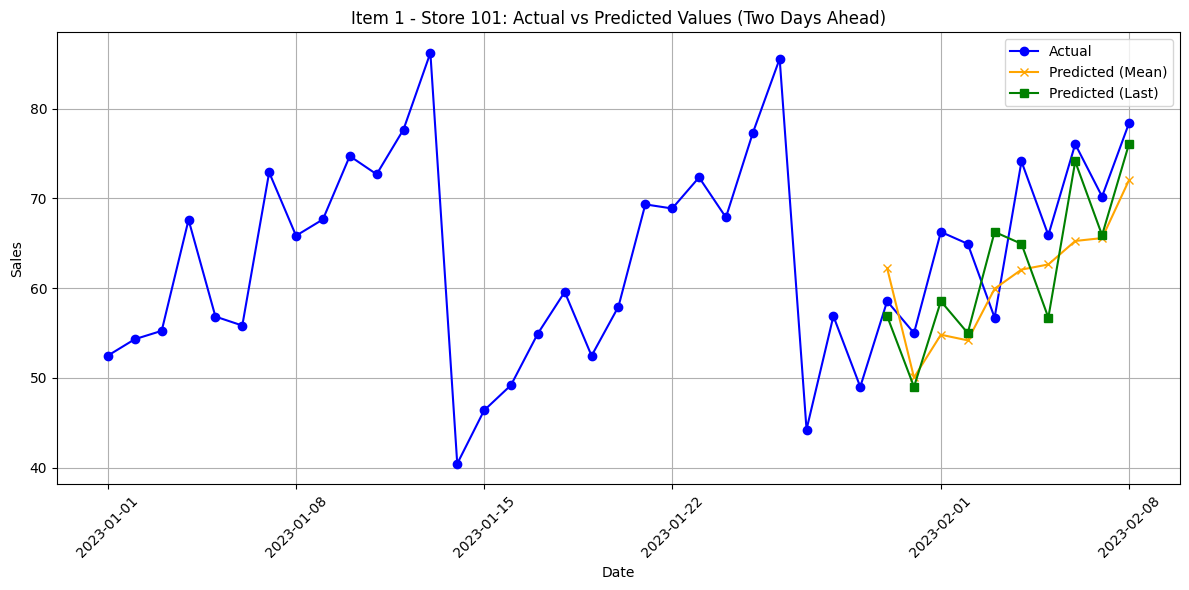

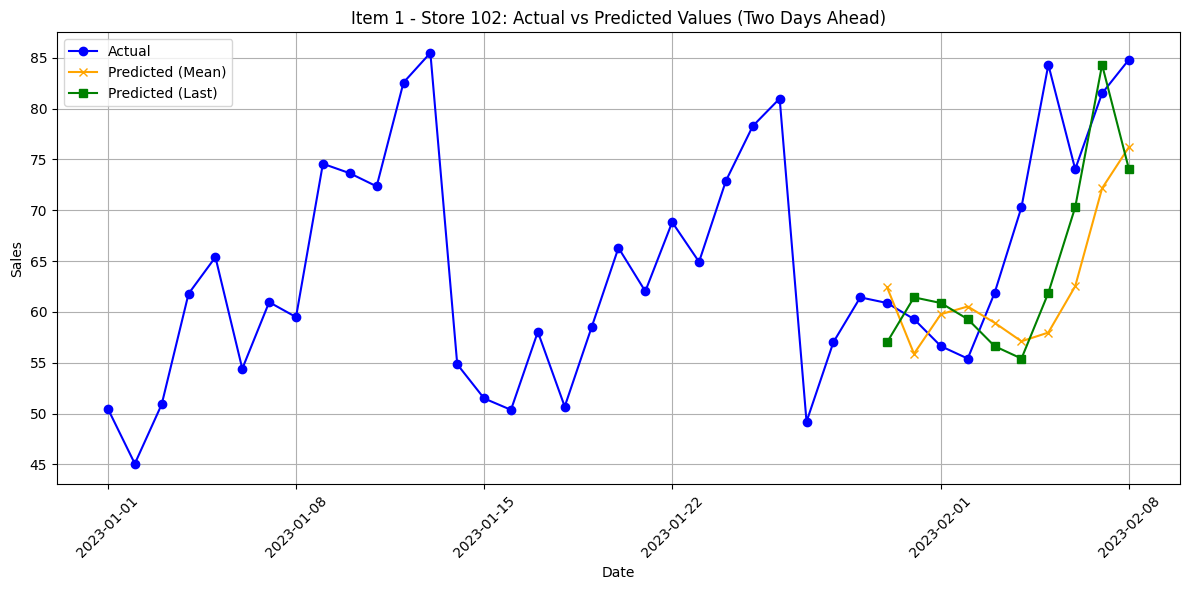

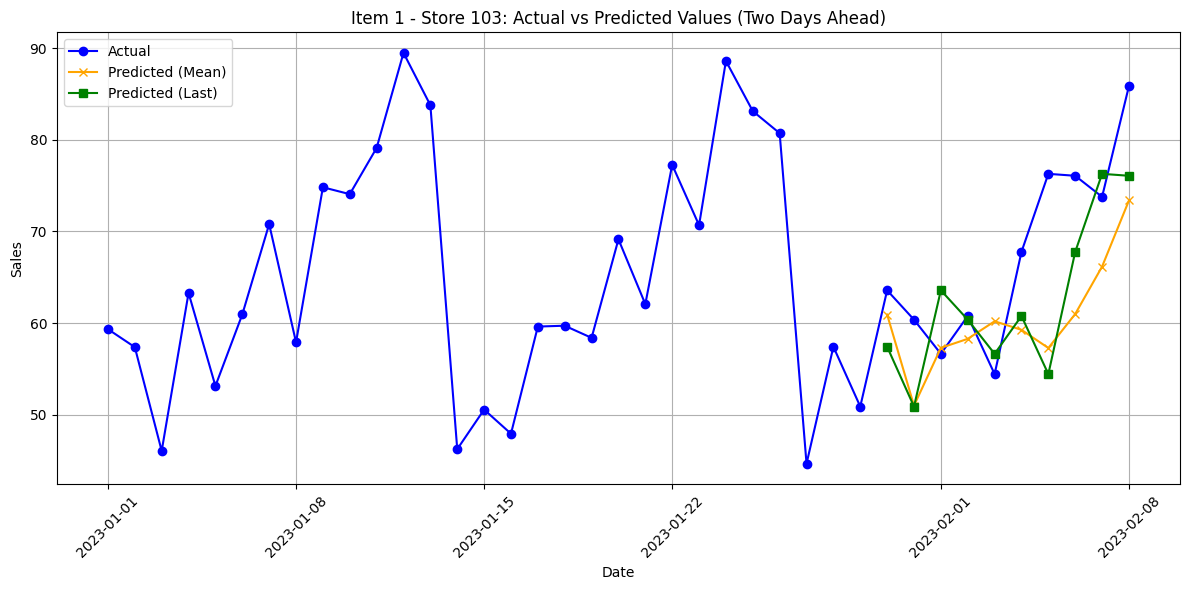

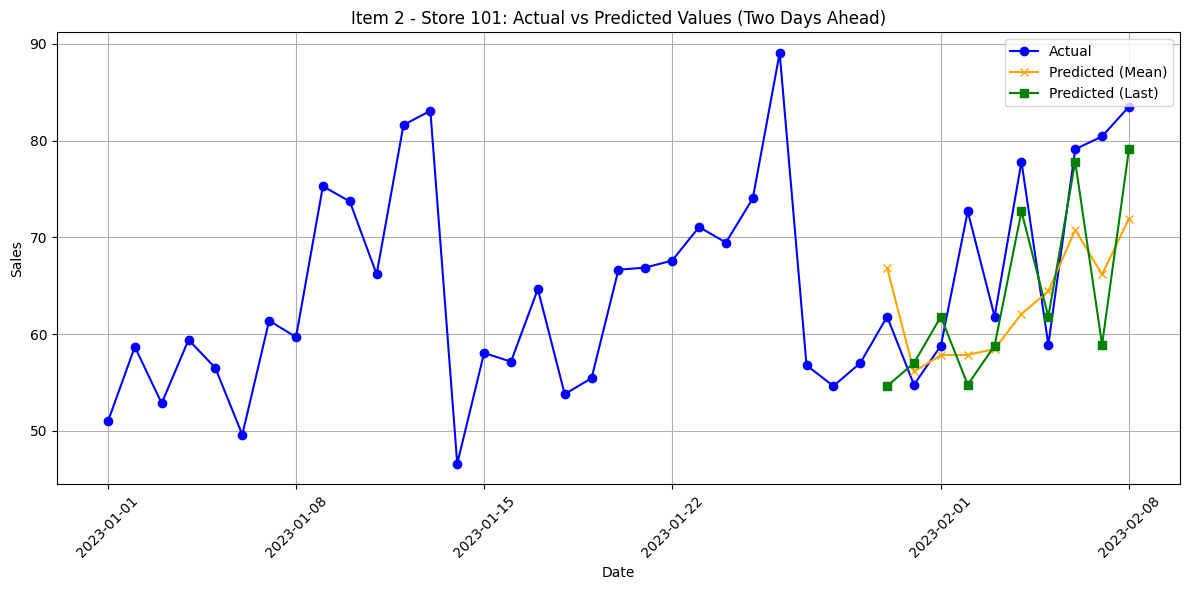

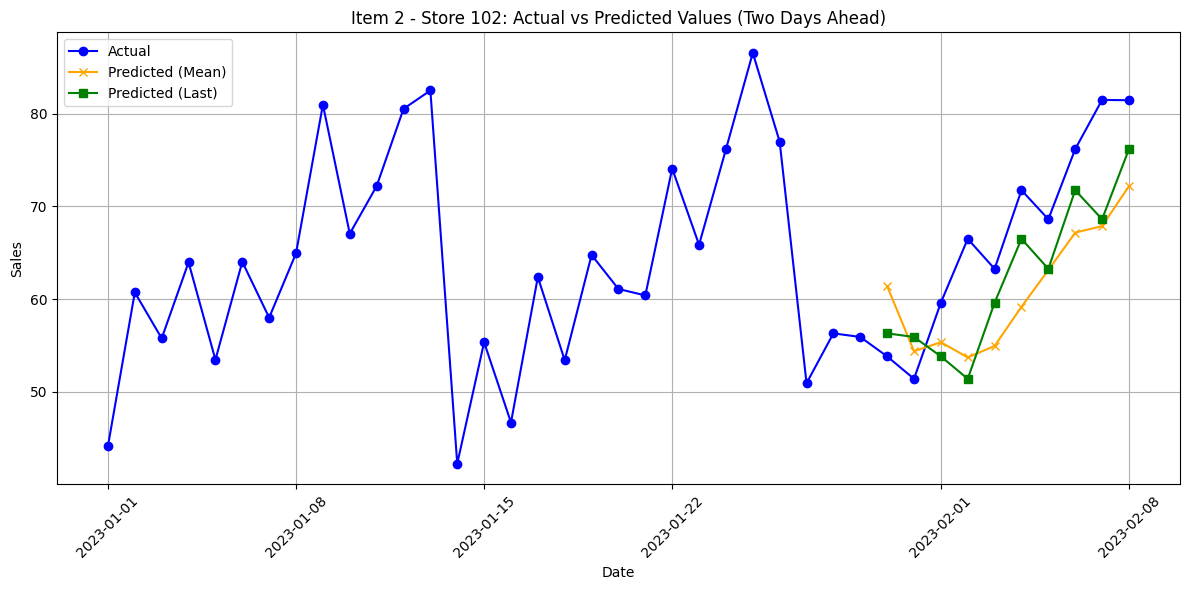

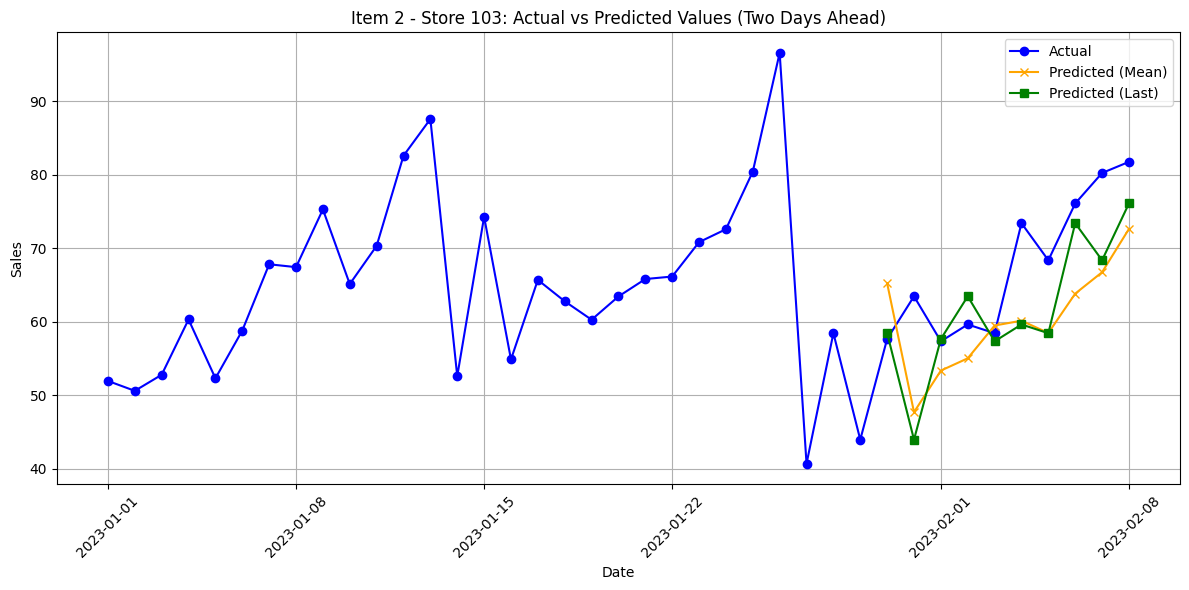

         date  item  store      sales  Predicted Last  Predicted Mean
0  2023-01-01     1    101  52.483571             NaN             NaN
1  2023-01-02     1    101  54.308678             NaN             NaN
2  2023-01-03     1    101  55.238443             NaN             NaN
3  2023-01-04     1    101  67.615149             NaN             NaN
4  2023-01-05     1    101  56.829233             NaN             NaN
5  2023-01-06     1    101  55.829315             NaN             NaN
6  2023-01-07     1    101  72.896064             NaN             NaN
7  2023-01-08     1    101  65.837174             NaN             NaN
8  2023-01-09     1    101  67.652628             NaN             NaN
9  2023-01-10     1    101  74.712800             NaN             NaN
10 2023-01-11     1    101  72.682912             NaN             NaN
11 2023-01-12     1    101  77.671351             NaN             NaN
12 2023-01-13     1    101  86.209811             NaN             NaN
13 2023-01-14     1 

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example multi-item, multi-store time series data with random variations
np.random.seed(42)  # For reproducibility

date_rng = pd.date_range(start='2023-01-01', end='2023-02-08', freq='D')  # Date range
items = [1, 2]  # Two items
stores = [101, 102, 103]  # Three stores

# Create a DataFrame with sales for each item-store combination with slight variation
data = []
for store in stores:
    for item in items:
        base_sales_data = np.array([50, 55, 52, 60, 58, 57, 65, 62, 70, 72, 75, 80, 85] * 3)
        variation = np.random.normal(loc=0, scale=5, size=len(base_sales_data))  # Adding some random variation
        sales_data = base_sales_data + variation
        for date, sales in zip(date_rng, sales_data):
            data.append([date, item, store, sales])

df = pd.DataFrame(data, columns=['date', 'item', 'store', 'sales'])

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

# Creating lagged and rolling mean features for each item-store combination
def add_lagged_features(group):
    group = group.sort_values('date')  # Ensure sorting by date
    group['Predicted Last'] = group['sales'].shift(2)  # Shift by 2 days for lag
    group['Predicted Mean'] = group['sales'].shift(2).rolling(window=3).mean()  # Rolling mean (t-2, t-3, t-4)
    
    # Keep only last 10 predictions for validation (train-test split)
    group['Predicted Mean'] = group['Predicted Mean'].where(group.index.isin(group.index[-10:]), np.nan)
    group['Predicted Last'] = group['Predicted Last'].where(group.index.isin(group.index[-10:]), np.nan)
    
    return group

# Apply the lagging and rolling mean functions for each (item, store) group
df = df.groupby(['item', 'store'], group_keys=False).apply(add_lagged_features).reset_index(drop=True)

# Calculate MAPE for the last 10 observations for each item-store group
mape_results = df.groupby(['item', 'store']).apply(
    lambda group: pd.Series({
        'MAPE Mean': mean_absolute_percentage_error(group['sales'].tail(10), group['Predicted Mean'].tail(10)),
        'MAPE Last': mean_absolute_percentage_error(group['sales'].tail(10), group['Predicted Last'].tail(10))
    })
)

# Compute final average MAPE across all item-store combinations
final_mape_mean = mape_results['MAPE Mean'].mean()
final_mape_last = mape_results['MAPE Last'].mean()

print("Final Average MAPE (Mean Forecast): {:.2f}%".format(final_mape_mean))
print("Final Average MAPE (Last Forecast): {:.2f}%".format(final_mape_last))

# Plotting Actual vs Predicted (Mean and Last) for each item-store with distinct series
for (item, store), group in df.groupby(['item', 'store']):
    plt.figure(figsize=(12, 6))
    plt.plot(group['date'], group['sales'], label='Actual', marker='o', color='blue')
    plt.plot(group['date'], group['Predicted Mean'], label='Predicted (Mean)', marker='x', color='orange')
    plt.plot(group['date'], group['Predicted Last'], label='Predicted (Last)', marker='s', color='green')
    
    plt.title(f'Item {item} - Store {store}: Actual vs Predicted Values (Two Days Ahead)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Preview the first 20 rows for a specific item-store combination
print(df[(df['item'] == 1) & (df['store'] == 101)].head(20))
